This is going to be an exploration into the data from Boston Airbnb listings. We'll try to find patterns based on many features including transit options, minimum nights of stay, latitude, and newness of the host and observe the effects on price and ratings. First off, we'll start by filtering the data to certain features and clean up a bit, and check out the correlation on a heatmap.

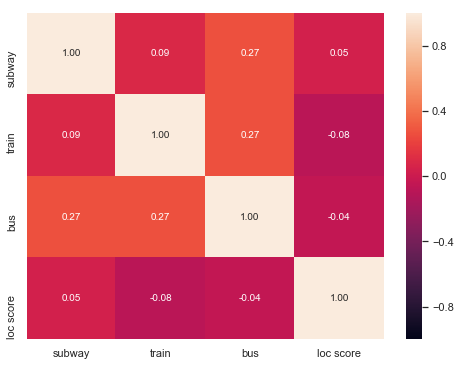

In [55]:
import folium
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


def clean(x): # to convert the prices to float values
    x = x.replace("$", "").replace(",", "").replace('.00', '')
    return float(x)


df = pd.read_csv('listings.csv') # get only the relevant columns below
df1 = df[['room_type', 'transit', 'latitude',
    'longitude', 'host_neighbourhood', 'summary', 'host_id',
    'minimum_nights', 'host_identity_verified', 'guests_included', 'price',
    'host_is_superhost', 'reviews_per_month', 'review_scores_location', 
    'review_scores_rating']].copy()
df1.loc[:,'price'] = df1['price'].apply(clean).copy()


def summary_length(row): # listing summary/description length
    if type(row['summary']) == float:
        return 0
    return len(row['summary'])


def extract(row, s): # new column based on if 'transit' contains T or subway
    if type(row['transit']) == float:
        return 0
    if s in row['transit']:
        return 1
    else:
        return 0


def bool_to_num(row, s):
    if row[s] == 't':
        return 1
    else:
        return 0




df1['subway'] = df1.apply(extract, s = 'subway', axis = 1)
df1['train'] = df1.apply(extract, s = 'train', axis = 1)
df1['bus'] = df1.apply(extract, s = 'bus', axis = 1)
df1['summary length'] = df1.apply(summary_length, axis = 1)
df1["verified host"] = df1["host_identity_verified"].map(
    {'t': 1, 'f': 0})
df1["superhost"] = df1.apply(bool_to_num, s = 'host_is_superhost', axis = 1)


plt.subplots(figsize = (8,6))

df1 = df1.rename(columns={'review_scores_location':'loc score',
                          'reviews_per_month': 'reviews per month',
                          'guests_included': 'guests included',
                          'review_scores_rating': 'overall rating',
                          'minimum_nights': 'minimum nights',
                          'room_type': 'room type',
                          'host_id': 'host ID'
                         })

sns.heatmap(df1[['subway', 'train', 'bus', 'loc score']].corr(),
    annot = True, fmt = '.2f', vmin=-1);

Question 1: How does the mention of 'train', 'subway' or 'bus' in transit affect the reviews_score_location?

Looking at the heatmap, surprisingly we see a slightly negative correlation with the keyword 'bus' and 'train' in the transit description at -0.04 and -0.08 respectively whereas the keyword 'subway' has a slightly positive correlation 0.05. The word 'train' can be used interchangeably with 'T' or 'subway' in Boston area, but in this case it likely refers to the commuter rail. Both buses and commuter rails serve areas that are further from downtown Boston as opposed to the subway, so it seems fair that there is some correlation.



Now let's try to answer another question. What makes someone a 'superhost'?

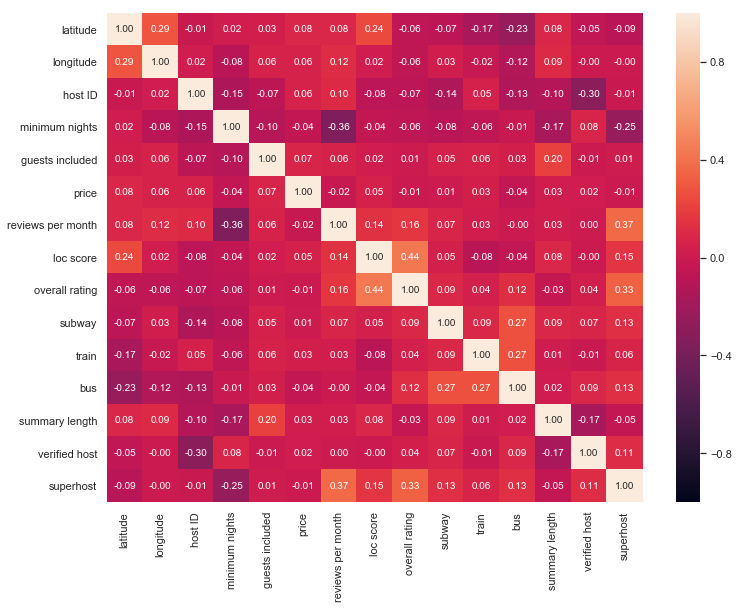

In [56]:
plt.subplots(figsize = (12,9))
sns.heatmap(df1.corr(), annot = True, fmt = '.2f', vmin=-1);

Looking at the bottom row, we can see the three most relevant features. Superhosts, not-so-surprisingly, have higher overall ratings and more reviews per month, but they also have a lower number of minimum night requirement. Minimum night requirement is also strongly correlated with the number of reviews per month, so it wouldn't be far fetched to assume a major reason someone ended up as a superhost is that they set a lower number for the minimum nights of stay. Since the 'superhost' label is clearly displayed on listings, it might be a good beginning strategy to be less selective and start with as small as possible for the minimum number of nights of stay.

All right, so, what's the relation between the overall rating, reviews per month and someone being a superhost?

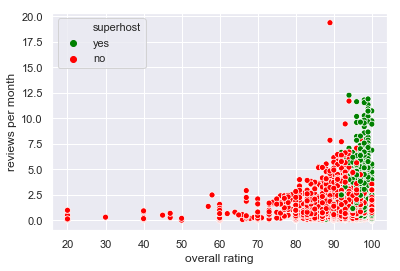

In [57]:
df1["superhost"] = df1["superhost"].map({1: 'yes', 0: 'no'})
g =sns.scatterplot(x="overall rating", y="reviews per month",
              hue="superhost", palette=['green','red'], legend='full',
              data=df1);

It's no surprise that pretty much all the green points(superhost) have an overall rating of at least 90 out of 100. And intuitively, I thought, there would be a minimum number of reviews per month(or overall) to be a superhost, but neither are the case! So if you're providing excellent service on AirBnB, you have good odds at getting the superhost label that gives you a nice promotion. But even if you have a perfect score with 3 reviews per month, which seems often, you might still not be a superhost.

Now, let's answer the following question. What are the 10 most popular AirBnB locations in Boston with a perfect rating average of 100%?

In [58]:
m = folium.Map(
    location = [42.3601, -71.0589],
    zoom_start = 12,
    tiles = 'cartodbpositron'
)

# Finding the most popular spots with 100/100 score
df1_popular = df1.loc[df1['overall rating'] == 100]
top_ten = df1_popular.nlargest(10,'reviews per month')

col = ['lightblue', 'pink', 'darkred', 'lightred', 'red', 'lightgreen',
    'blue', 'darkpurple', 'orange', 'green']
for i in range(10):
    current = top_ten.iloc[i]
    folium.Marker(
    location = [current['latitude'],current['longitude']], # coordinates
    popup = str(current['host_neighbourhood']) + ' $' + str(current['price']),
    icon = folium.Icon(icon = 'heart', color = col[i])).add_to(m)

m

Wow! All over the place around Boston, well, apart from East Boston. We got expensive places in Downtown(convenient), Beacon Hill(affluent) and South End, cheap places in Dorchester(surprise surprise!), and moderately priced Allston/Brighton and Jamaica Plain where many college students and young professionals live. It seems that you can list a property anywhere in Boston, and there will be a big demand! Who wants to pay the exorbitant hotel prices in Boston?

Now let's look at the distribution of room type attribute for the properties in Boston and see which ones are the most commonly available and get an idea about which ones get booked the most often. While we don't have data for booking rate, we know the rate of reviews per month for each property, and so that gives us a rough idea about the popularity of different room types. What's the most popular type of room on AirBnB? Private room, entire home, or something else?

Average number of reviews per month:
Entire home average: 1.78
Private room average: 1.91
Shared room average: 1.56
Hotel room average: 0.95


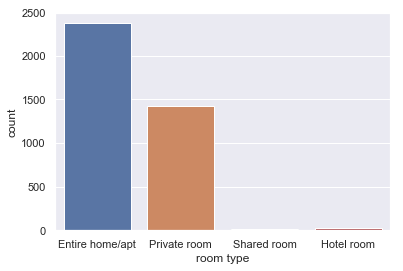

In [59]:
# Now let's see how often these room types are booked
entire_freq, private_freq, shared_freq, hotel_freq = 0.0, 0.0, 0.0, 0.0
entire_count, private_count, shared_count, hotel_count = 0, 0, 0, 0
for index, row in df1.iterrows():
    freq = row['reviews per month']
    if not math.isnan(freq):
        room_type = row['room type']
        if room_type == 'Entire home/apt':
            entire_freq += freq
            entire_count += 1
        if room_type == 'Private room':
            private_freq += freq
            private_count += 1
        if room_type == 'Shared room':
            shared_freq += freq
            shared_count += 1
        if room_type == 'Hotel room':
            hotel_freq += freq
            hotel_count += 1
# print(entire_freq, private_freq, shared_freq, hotel_freq)
# print(entire_count, private_count, shared_count, hotel_count)
print("Average number of reviews per month:")
print("Entire home average: " + str(round(entire_freq / entire_count, 2)))
print("Private room average: " + str(round(private_freq / private_count, 2)))
print("Shared room average: " + str(round(hotel_freq / hotel_count, 2)))
print("Hotel room average: " + str(round(shared_freq / shared_count, 2)))

sns.set(style = "darkgrid")
ax = sns.countplot(x = "room type", data = df1)

As we can see entire home/apt and private room are both popular options high in supply and demand on AirBnB. But it seems that private room has an edge over entire home for the number of reviews per month. And this is despite private room option also averaging slightly higher minimum number of nights of stay. So AirBnB's appeal to homeowners making extra cash by renting out their spare room seems valid. Would you do it? Seems like a worth a try!